# Project Overview

This notebook explores the Energy Efficiency dataset and establishes a baseline machine learning workflow for predicting building heating and cooling load.

# Problem Statement

The goal of this project is to predict the heating and cooling load of buildings based on geometric and glazing parameters using supervised machine learning.

# Dataset

The Energy Efficiency dataset was obtained from the UCI Machine Learning Repository. It contains simulated building data with geometric features and energy load targets.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("../data/raw/energy_efficiency.xlsx")
df.columns = [
    "Relative Compactness",
    "Surface Area",
    "Wall Area",
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution",
    "Heating Load",
    "Cooling Load"
]
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [14]:
df.shape
df.columns
df.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


# Exploratory Data Analysis

## This section explores the distributions of the input features and their relationships with the heating and cooling load targets.

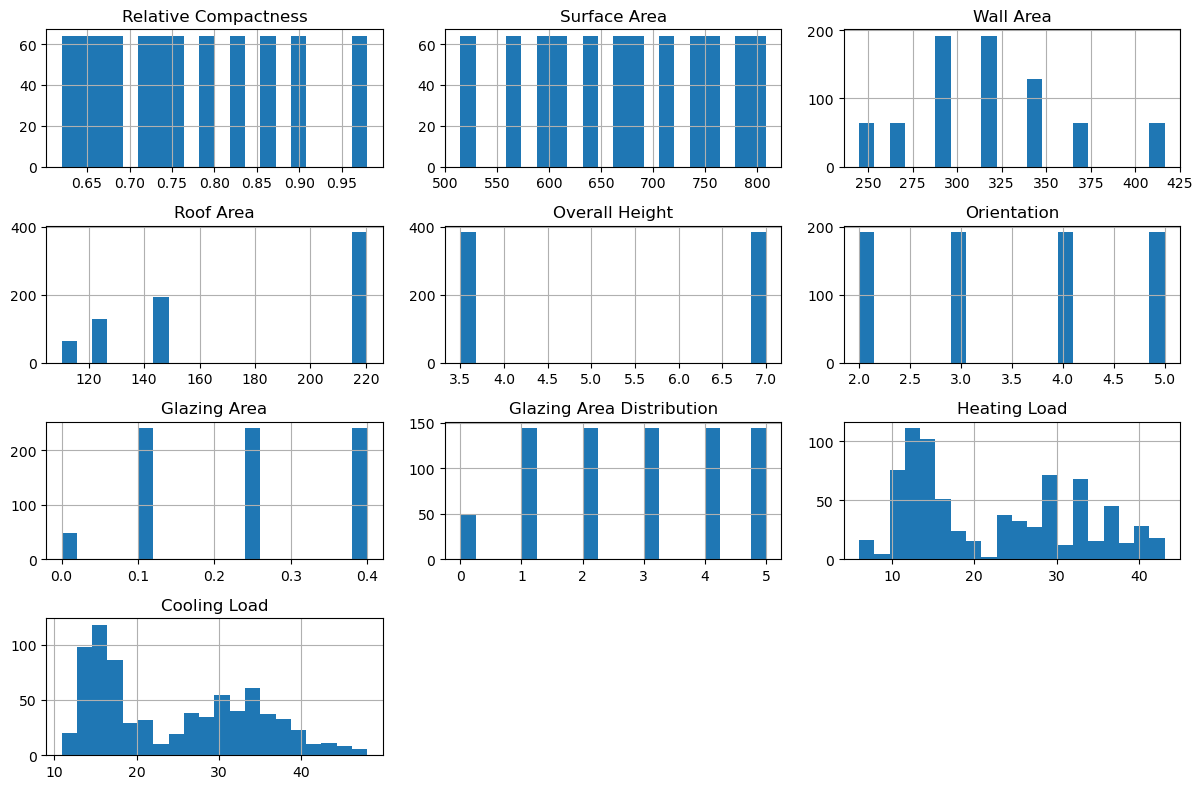

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("../data/raw/energy_efficiency.xlsx")
df.columns = [
    "Relative Compactness",
    "Surface Area",
    "Wall Area",
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution",
    "Heating Load",
    "Cooling Load"
]
df.hist(figsize=(12,8), bins=20)
plt.tight_layout()
plt.show()

Most features show distributions with no extreme outliers. Orientation and glazing distribution appear as discrete variables.

In [16]:
corr = df.corr()
corr["Heating Load"].sort_values(ascending=False)

Heating Load                 1.000000
Cooling Load                 0.975862
Overall Height               0.889430
Relative Compactness         0.622272
Wall Area                    0.455671
Glazing Area                 0.269842
Glazing Area Distribution    0.087368
Orientation                 -0.002587
Surface Area                -0.658120
Roof Area                   -0.861828
Name: Heating Load, dtype: float64

Heating Load shows strong correlation with overall height and surface area, indicating that ubilding geometry significantly impacts energy demand.

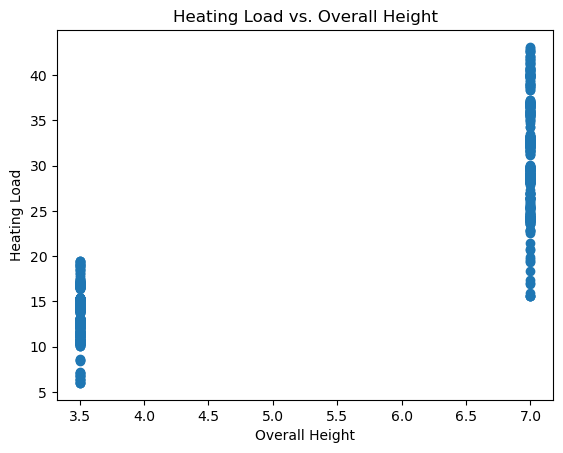

In [25]:
plt.scatter(df["Overall Height"], df["Heating Load"])
plt.xlabel("Overall Height")
plt.ylabel("Heating Load")
plt.title("Heating Load vs. Overall Height")
plt.show()

As overall building height increases, heating load increases as well, which is consistent with the building's increased thermal envelope.

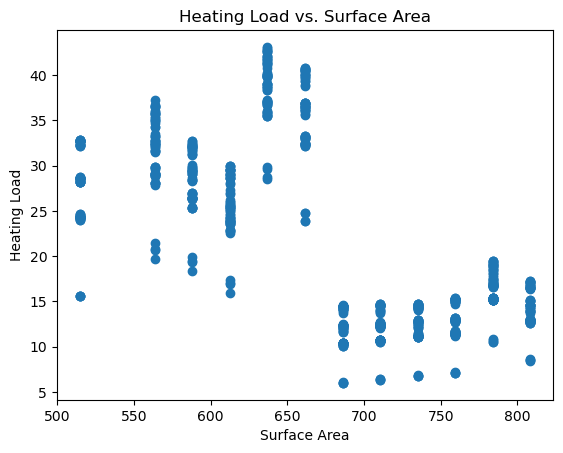

In [26]:
plt.scatter(df["Surface Area"], df["Heating Load"])
plt.xlabel("Surface Area")
plt.ylabel("Heating Load")
plt.title("Heating Load vs. Surface Area")
plt.show()

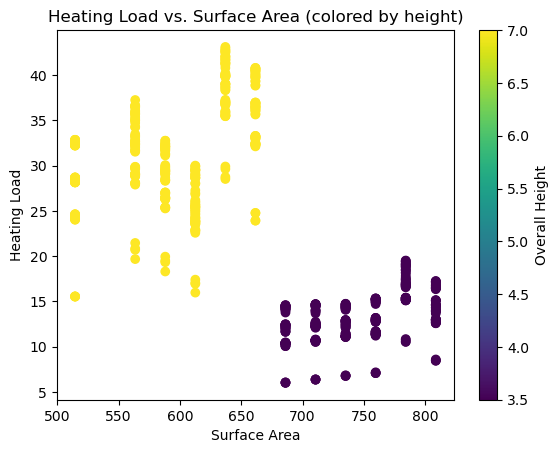

In [29]:
plt.scatter(
    df["Surface Area"],
    df["Heating Load"],
    c=df["Overall Height"],
    cmap="viridis"
)
plt.colorbar(label="Overall Height")
plt.xlabel("Surface Area")
plt.ylabel("Heating Load")
plt.title("Heating Load vs. Surface Area (colored by height)")
plt.show()

Unlike overall height, surface area alone does not show a strong monotonic relationship with heating load. This suggests that heating demand depends on mulitple interacting gemoetric features than a single parameter, such as building height.

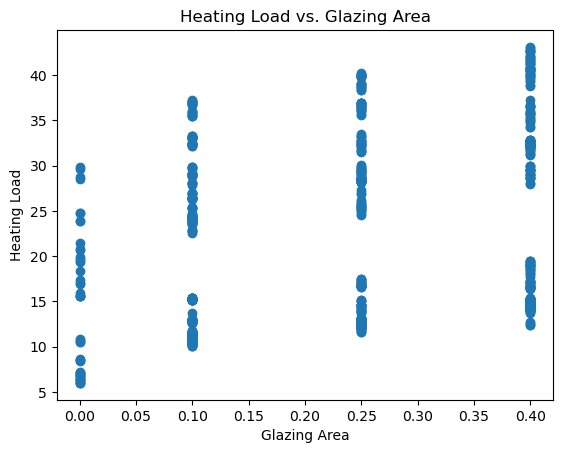

In [23]:
plt.scatter(df["Glazing Area"], df["Heating Load"])
plt.xlabel("Glazing Area")
plt.ylabel("Heating Load")
plt.title("Heating Load vs. Glazing Area")
plt.show()

Buildings with a larger glazing area tend to have higher heating loads, likely due to increased heat gain from conduction.

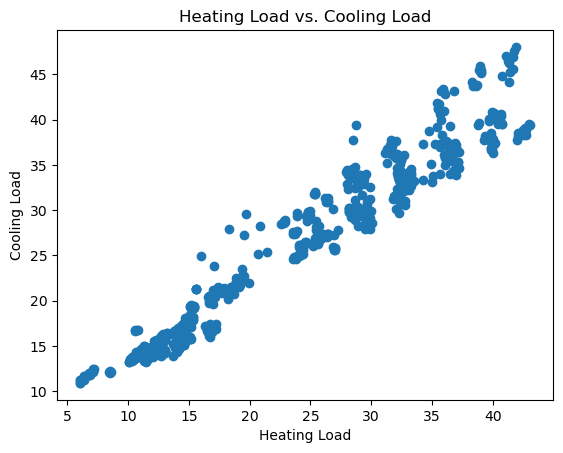

In [22]:
plt.scatter(df["Heating Load"], df["Cooling Load"])
plt.xlabel("Heating Load")
plt.ylabel("Cooling Load")
plt.title("Heating Load vs. Cooling Load")
plt.show()

Heating and Cooling Loads are correlated but not identical, suggesting separate models may be beneficial.

## Summary

Exploratory analysis suggests that factors such as overall height strongly influence heating load, however factors such as surface area require multiple interacting parameters to determine correlation with heating load, suggesting that surface area does not directly correlate to heating load.

# Linear vs. Nonlinear Model

## Preprocessing: Train-Test Split

The dataset is split into training and testing sets to evaluate model generalization performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("../data/raw/energy_efficiency.xlsx")
df.columns = [
    "Relative Compactness",
    "Surface Area",
    "Wall Area",
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution",
    "Heating Load",
    "Cooling Load"
]

from sklearn.model_selection import train_test_split

X = df.drop(columns=["Heating Load", "Cooling Load"])
y = df["Heating Load"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

X_train.shape, X_test.shape

((614, 8), (154, 8))

## Baseline Regression Model

A linear regression model is used as a baseline to establish initial performance for predicting heating load.

In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [6]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(3.0254268535103703), 0.9121846294352439)

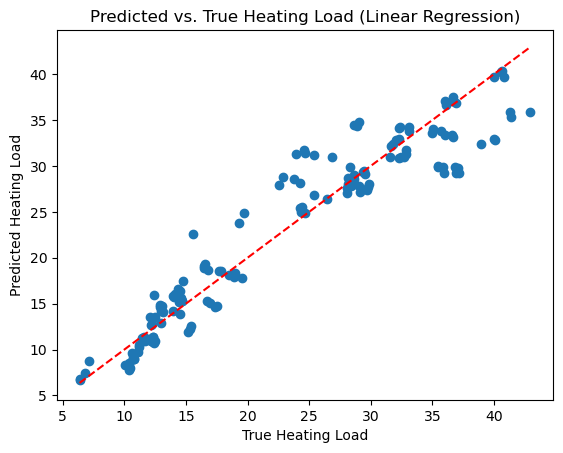

In [7]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("True Heating Load")
plt.ylabel("Predicted Heating Load")
plt.title("Predicted vs. True Heating Load (Linear Regression)")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.show()

The baseline linear regression model captures the overall trend in heating load but shows some dispersion, indicating room for improvement with more expressive models.

## Baseline Model Summary

Linear regression provides a strong baseline for predicting heating load. However, non-linear relationships observed during Exploratory Data Analysis suggest that more complex models may further improve performance.

## Feature Scaling and Pipelines

Feature scaling is applied to ensure that all input features contribute appropriately to the model. Pipelines are used to combine preprocessing and baseline linear regression modeling steps in a reproducible workflow.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("../data/raw/energy_efficiency.xlsx")
df.columns = [
    "Relative Compactness",
    "Surface Area",
    "Wall Area",
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution",
    "Heating Load",
    "Cooling Load"
]

from sklearn.model_selection import train_test_split

X = df.drop(columns=["Heating Load", "Cooling Load"])
y = df["Heating Load"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)

y_pred_lr = linreg_pipeline.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

rmse_lr, r2_lr

(np.float64(3.025426853510373), 0.9121846294352438)

## Nonlinear Model: Random Forest

A Random Forest regressor is trained to capture nonlinear relationships between building features and heating load.

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators = 200,
    random_state = 42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, r2_rf

(np.float64(0.49263804987213333), 0.9976716239233653)

## Model Comparison: Linear vs. Nonlinear

The performance of linear regression and random forest models is compared to evaluate the benefits of nonlinear modeling.

In [10]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf]
})

results

,Model,RMSE,R2
0,Linear Regression,3.025427,0.912185
1,Random Forest,0.492638,0.997672


The Random Forest model outperforms linear regression with both a much lower RMSE value and a higher R2 value, indicating that nonlinear interactions between building features play a significant role in determining heating load.

## Feature Importance Using Random Forest Model

In [12]:
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance.sort_values(ascending=False)

Relative Compactness         0.398075
Surface Area                 0.209936
Overall Height               0.142702
Roof Area                    0.123811
Glazing Area                 0.078461
Wall Area                    0.034198
Glazing Area Distribution    0.012062
Orientation                  0.000755
dtype: float64

Relative Compactness, Surface Area, and Overall Height are among the most important features when considering heating load, which is consistent with insights from Exploratory Data Analysis.

# Evaluation

# Conclusion and Next Steps